###### Версия работает для 32-bit версии Python

In [1]:
%load_ext autoreload
%autoreload 2
import sys
print(sys. version)

3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:21:31) [MSC v.1936 32 bit (Intel)]


In [2]:
import utils as lu

In [4]:
# Проверка установки библиотеки
lu.get_library_version()

Версия библиотеки: 1.1.19.0


In [6]:
# Проверка подключенных устройст
available_dev = lu.get_number_available_dev()

# Подключение к нулевому устройству
hnd = lu.connect_to_dev(available_dev, 0)

Количество доступных устройств: 1
№ 1, устройство E502, серийный номер 5T707204, USB


In [7]:
# Информация о подключенном устройстве
lu.get_device_info(hnd)

Установлена связь со следующим модулем:
 Серийный номер: 5T707204
 Наличие ЦАП: Да
 Наличие BlackFin: Да
 Наличие гальваноразвязки:Да
 Индустриальное исп.     :Да
 Наличие интерф. PCI/PCIe:Нет
 Наличие интерф. USB     :Да
 Наличие интерф. Ethernet:Да
 Версия ПЛИС: 0.14
 Версия PLDA: 2
 Версия прошивки ARM: 1.0.20.0


##### АЦП

In [10]:
ch_num = [0, 1, 2, 3] # Номера каналов АЦП
ch_modes = [1, 1, 1, 1] # Для каждого канала дифф. вход
ch_ranges = [2, 2, 2, 2]  # Для каждого канала диапазон от -5 до +5 Вольт
avg = 1 # Без усреднения
# Установка парметров для устройства
lu.set_param_channel(hnd, ch_num, ch_modes, ch_ranges, avg)

In [11]:
freq_adc = 2_000_000 # Количество отсчётов в секунду для АЦП
freq_frame = 2_000_000 # Количество отсчётов в секунду на кадр (при такой каонфигурации межкадровая задержка нулевая)
freq_din = 2_000_000 # Количество отсчётов в секунду для цифровых входах

# Установка скорости на устройстве
_, channel_freq, _ = lu.set_rate_adc_din(hnd, freq_adc, freq_frame, freq_din)

print(f"На каждый канал {round(channel_freq)} Гц")
print(f"Это {1000 * round(channel_freq) / freq_adc} миллисекунд записи, при общей длине записи в 1000 отсчётов")

На каждый канал 500000 Гц
Это 250.0 миллисекунд записи, при общей длине записи в 1000 отсчётов


In [13]:
block_size = 500_000 # Количество отсчётов на все каналы АЦП
timeout = 1000 # Количество миллисекунд ожидания данных с АЦП
n_ch = len(ch_num) # Количесво каналов 

# Считать данные с АЦП
data = lu.read_adc_data(hnd, block_size, timeout, n_ch)

In [119]:
lu.errors.err_dict[lu.x502.X502_Close(hnd)]

' Функция выполнена без ошибок '

##### ЦАП

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [16]:
# Создание сигналов

# синус
time = np.linspace(0, 1, 500_000)
freq = 111
sin = np.sin(freq * 2 * np.pi * time)

# импульс
signal = np.zeros(500_000) + 5
signal[:1000] = -5
signal[-1000:] = -5

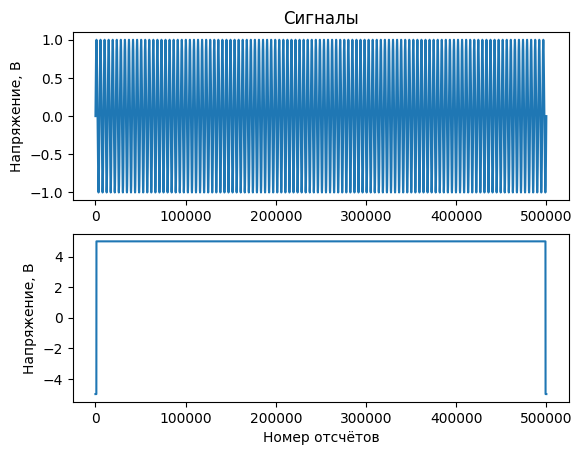

In [29]:
fig, ax = plt.subplots(2, 1)

ax[0].set_title("Сигналы")
ax[0].plot(sin)
ax[0].set_ylabel("Напряжение, В")

ax[1].plot(signal)
ax[1].set_ylabel("Напряжение, В");
ax[1].set_xlabel("Номер отсчётов");

In [34]:
# Воспроизведение в циклическом режиме
lu.write_dac_data_cycle(hnd, sin, signal, start_stream=True) # Запись двух каналов 
lu.write_dac_data_cycle(hnd, sin, None, start_stream=True) # Запись первого канала
lu.write_dac_data_cycle(hnd, None, signal, start_stream=True) # Запись второго канала

lu.write_dac_data_cycle(hnd, sin, signal, start_stream=False) # Запись каналов каналов, но без записи потока

# Запускаем поток
ierr = lu.x502.X502_StreamsStart(hnd)
if ierr != 0:
    print(f'Ошибка {ierr}, {lu.errors.err_dict[ierr]}')

time.sleep(5)    

# Останавливаем поток
ierr = lu.x502.X502_StreamsStop(hnd)
if ierr != 0:
    print(f'Ошибка {ierr}, {lu.errors.err_dict[ierr]}')

In [35]:
# Воспроизведение единожды
lu.write_dac_data(hnd, sin, signal, start_stream=True) # Запись двух каналов 
lu.write_dac_data(hnd, sin, None, start_stream=True) # Запись первого канала
lu.write_dac_data(hnd, None, signal, start_stream=True) # Запись второго канала

lu.write_dac_data(hnd, sin, signal, start_stream=False) # Запись каналов каналов, но без записи потока

# Запускаем поток
ierr = lu.x502.X502_StreamsStart(hnd)
if ierr != 0:
    print(f'Ошибка {ierr}, {lu.errors.err_dict[ierr]}')

time.sleep(5)    

# Останавливаем поток
ierr = lu.x502.X502_StreamsStop(hnd)
if ierr != 0:
    print(f'Ошибка {ierr}, {lu.errors.err_dict[ierr]}')

##### ЦАП + АЦП

In [36]:
readed_data = lu.sync_write_read(hnd, sin, signal, block_size, timeout, n_ch)